# M3R Numerics

In [1]:
import numpy as np
import math as m
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

plt.rcParams['figure.dpi'] = 300


First we implement a class to represent a normal random variable.

In [152]:
class NormalRV:
    """
    Class for a multivariate normal random variable.
    """

    def __init__(self, mu, Sigma, fundamental = False):
        """
        Constructor. Sets:
        - mu (np.array): mean
        - Sigma (np.matrix): covariance matrix
        - S (np.matrix): inverse of Sigma
        - m (np.array): S@mu
        """
        if not fundamental:
            self.mu = mu
            self.Sigma = Sigma
            self.S = np.linalg.inv(Sigma)
            self.m = self.S@self.mu
        else:
            self.m = mu
            self.S = Sigma
            self.Sigma = np.linalg.inv(Sigma)
            self.mu = self.Sigma @ self.m
        self.dim = len(mu)
    
    def pdf(self, x):
        """
        Evaluates the pdf at x. x can be a vector or a matrix; in the latter case, 
        the pdf is evaluated column-wise.

        Args:
        - x (np.array): point(s) at which to evaluate the pdf

        Returns:
        - pdf (np.array): pdf evaluated at x
        """

        mu = self.mu
        S = self.S
        Sigma = self.Sigma
        d = len(mu)
        x = np.asarray(x)
        if x.ndim == 1:
            x = x[:, np.newaxis]
        n = x.shape[1]
        pdf = np.zeros(n)
        for i in range(n):
            pdf[i] = 1/np.sqrt((2*np.pi)**d * np.linalg.det(Sigma)) * \
                np.exp(-1/2 * (x[:,i] - mu).T @ S @ (x[:,i] - mu))
        return pdf

    def sample(self, n):
        """
        Draws n samples from the distribution.

        Args:
        - n (int): number of samples to draw

        Returns:
        - samples (np.array): samples drawn from the distribution
        """

        return np.random.multivariate_normal(self.mu, self.Sigma, n).T
    
    def construct_ellipse(self, n_std, ax, color, label ):
        pearson = self.Sigma[0, 1]/np.sqrt(self.Sigma[0, 0] * self.Sigma[1, 1])
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor='none', edgecolor=color, label=label)
        scale_x = np.sqrt(self.Sigma[0, 0]) * n_std
        scale_y = np.sqrt(self.Sigma[1, 1]) * n_std
        mu_x = self.mu[0]
        mu_y = self.mu[1]

        transform = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mu_x, mu_y)
        
        ellipse.set_transform(transform + ax.transData)
        return ax.add_patch(ellipse)

        
    
    def __str__(self):
        """
        Returns a string representation of the distribution.
        """

        return "N(" + str(self.mu) + ", " + str(self.Sigma) + ")"
    
    def __repr__(self):
        """
        Returns a string representation of the distribution.
        """

        return "N(" + str(self.mu) + ", " + str(self.Sigma) + ")"
        

Note that our update step is:

$$
\theta_{n+1}\leftarrow \theta_n - \alpha \nabla \rho(\theta)
$$

In our case, as both distributions are normal, we can use the fundamental representation of the normal distribution so that its pdf is in the exponential family. This means that:

$$
\nabla \rho(\theta) = \int_{\mathbb{R}^n}-\frac{\pi^2(x)}{q^2_\theta(x)}\nabla\log q_\theta(x) dx
$$

Then, as $\theta = (\mu, \Sigma)$ and using the fundamental representation of the normal distribution we arrive to:

$$
\begin{align*}
\frac{\partial \log}{\partial m}(x) &= x-S^{-1}m = x-\mu\\
\frac{\partial \log}{\partial S}(x) &= -\frac{1}{2}(xx^\top - S^{-1}mm^\top S^{-1} - S^{-1}) = -\frac{1}{2}(xx^\top - \mu\mu^\top - \Sigma)
\end{align*}
$$

Therefore, we will implement gradient descent on $S$ and $m$, which is just are just invertible functions of $\Sigma$ and $\mu$.

We now implement functions to compute the gradient descent update, using the equations above:

In [153]:
def partial_lq_m(x, p):
    """
    Computes the partial derivative of the log-likelihood function with respect to the mean.

    Args:
    - x (np.array): point at which to evaluate the partial derivative
    - p (NormalRV): distribution

    Returns:
    - partial (np.array): partial derivative of the log-likelihood function with respect to the mean
    """

    partial = x - np.reshape(p.mu, (len(p.mu), 1))
    return partial

def partial_lq_S(x, p):
    """
    Computes the partial derivative of the log-likelihood function with respect to the covariance matrix.

    Args:
    - x (np.array): point at which to evaluate the partial derivative
    - p (NormalRV): distribution

    Returns:
    - res (np.array): partial derivative of the log-likelihood function with respect to the covariance matrix
    """

    x = np.asarray(x)
    if x.ndim == 1:
        x = x[:, np.newaxis]
    n = x.shape[1]
    d = len(p.mu)
    res = np.zeros((d,d,n))
    for i in range(n):
        xi = x[:,i]
        res[:,:,i] = -0.5*(np.outer(xi, xi) - np.outer(p.mu, p.mu)- p.Sigma)
    return res


Below is the implementation of a function that checks if a matrix is positive definite by trying to compute its Cholesky decomposition. If it fails, it means that the matrix is not positive definite.

In [154]:
def is_pd(M):
    """
    Checks if matrix is in the positive definite cone using the Cholesky decomposition.

    Args:
    - M (np.matrix): matrix to check
    """

    try:
        _ = np.linalg.cholesky(M)
        return True
    except np.linalg.LinAlgError:
        return False

Lastly, projection onto the cone of positive definite matrices is implemented below. This is done by computing the eigenvalue decomposition of the matrix and then projecting the eigenvalues onto the cone of positive real numbers (in code, this is done by setting $\lambda \leq 0$ to $\lambda = \varepsilon>0$ where $\varepsilon$ is small, of the order of $10^{-6}$).

In [155]:
def project_pd(M, eps=1e-2, set_val=0.001):
    """
    Projects a matrix to the positive definite cone. If the matrix is already in the positive definite cone, 
    it is returned unchanged.

    Args:
    - M (np.matrix): matrix to project
    - eps (float): tolerance to set negative and zero eigenvalues to
    - set (float): set negative and zero eigenvalues to this value


    Returns:
    - M (np.matrix): projected matrix
    """
    # project a matrix to the positive definite cone
    # M: a symmetric matrix
    # return: a symmetric matrix
    if is_pd(M):
        return M
    print("projecting")
    # projection to the positive definite cone
    eigval, eigvec = np.linalg.eigh(M)
    eigval[eigval <= eps] = set_val
    return eigvec.T @ np.diag(eigval) @ eigvec

We now implement OAIS, using the following steps for each iteration:

1. Sample $x\sim q_\theta(x)$
2. Compute $w_\theta(x) = \frac{\pi(x)}{q_\theta(x)}$
3. Estimate $(\phi, \pi_\theta^N)$ using the samples $x$ and $w_\theta(x)$
4. Update $\theta$ using the gradient descent by doing:
   1. Compute $\frac{\partial \log \rho}{\partial m}$ and update $m$
   2. Compute $\frac{\partial \log \rho}{\partial S}$ and update $S$ (project to PSD cone if needed)
   

In [202]:
def OAIS(phi, pi, q0, alpha, nsamples, niter):
    """
    Implement the OAIS algorithm.

    Args:
    - phi (function): test function to integrate against
    - pi (NormalRV): target distribution
    - q0 (NormalRV): initial distribution
    - alpha (float): learning rate scaling factor
    - nsamples (int): number of samples to draw at each iteration
    - niter (int): number of iterations

    Returns:
    - results (list): list of the results of the integration at each iteration
    - distributions (list): list of the distributions at each iteration
    """

    results = []
    distributions = [q0]
    for i in tqdm(range(niter)):
        lr = alpha/np.sqrt(i+1)
        # compute inner product
        samples = q0.sample(nsamples)
        w = pi.pdf(samples) / q0.pdf(samples) # compute w as we have access to pi
        w2 = w**2
        phi_samples = np.apply_along_axis(phi, 0, samples)
        integral = np.mean(w*phi_samples)
        results.append(integral)

        # update q0
        partial_m = partial_lq_m(samples, q0)
        update_m = -np.mean(w2 * partial_m, axis=1)
        
        partial_S = partial_lq_S(samples, q0)
        update_S = -np.mean(w2*partial_S, axis=2)
        new_S = project_pd(q0.S - lr*update_S) # BUG: projecting results in an ill conditioned matrix - FIX: project 0 eigenvalues to 1

        new_m = q0.m - lr*update_m
        
        q0 = NormalRV(new_m, new_S, fundamental=True)
        distributions.append(q0)

    return results, distributions

Let $Sq=[-1,\,1]^2$. We now test OAIS by using the test function $\phi(x) = 1_{Sq}(x)$. The target distribution will be:

$$
\pi\sim \mathcal{N}\left([1, -1]^\top, \begin{bmatrix} 2 & -0.5 \\ -0.5 & 2 \end{bmatrix}\right)
$$

And our initial proposal will be:
$$
q_{\theta_0} \sim \mathcal{N}\left([5, -5]^\top, \begin{bmatrix} 40 & 0 \\ 0 & 40 \end{bmatrix}\right)
$$

We estimate $\mathbb{P}(\pi\in Sq)$ using a Monte Carlo estimate with $N=10^6$ samples to obtain a reference value. To do this, we note that:

$$
\mathbb{P}(\pi\in Sq) = \int_{R_n}1_{Sq}(x)\pi(x)dx = \mathbb{E}[1_{Sq}(x)]\approx \frac{1}{N}\sum_{i=1}^N 1_{Sq}(x_i)
$$

Below, we define the functions to compute the reference value and the test function $\phi(x) = 1_{Sq}(x)$.

In [203]:
q = NormalRV(np.array([5, -5]), np.array([[40, 0], [0, 40]]))
pi = NormalRV(np.array([1, -1]), np.array([[2, -0.5], [-0.5, 2]]))

def phi(x):
    if np.abs(x)[0] < 1 and np.abs(x)[1] < 1:
        return 1
    else:
        return 0

def mc_estimate(phi, p, nsamples, return_samples=False):
    """
    Computes the Monte Carlo estimate of the integral of a function against a distribution.

    Args:
    - phi (function): function to integrate against
    - p (NormalRV): distribution
    - nsamples (int): number of samples to draw
    - return_samples (bool): whether to return the samples

    Returns:
    - integral (float): Monte Carlo estimate of the integral
    - x: samples, returned if return_samples is True
    """

    x = p.sample(nsamples)
    phi_x = np.apply_along_axis(phi, 0, x)
    int = np.mean(phi_x)
    if return_samples:
        return int, x
    return int

GT, x = mc_estimate(phi, pi, int(1e6), return_samples=True)
samples_cmap = np.apply_along_axis(phi, 0, x)
GT

In [ ]:
X = np.linspace(-20, 20, 100)
Y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((100, 100))
for i in range(100):
    for j in range(100):
        Z[i,j] = q.pdf(np.array([X[i,j], Y[i,j]]))

We now plot the results of the Monte Carlo estimate of the probability of a point being in $Sq$.

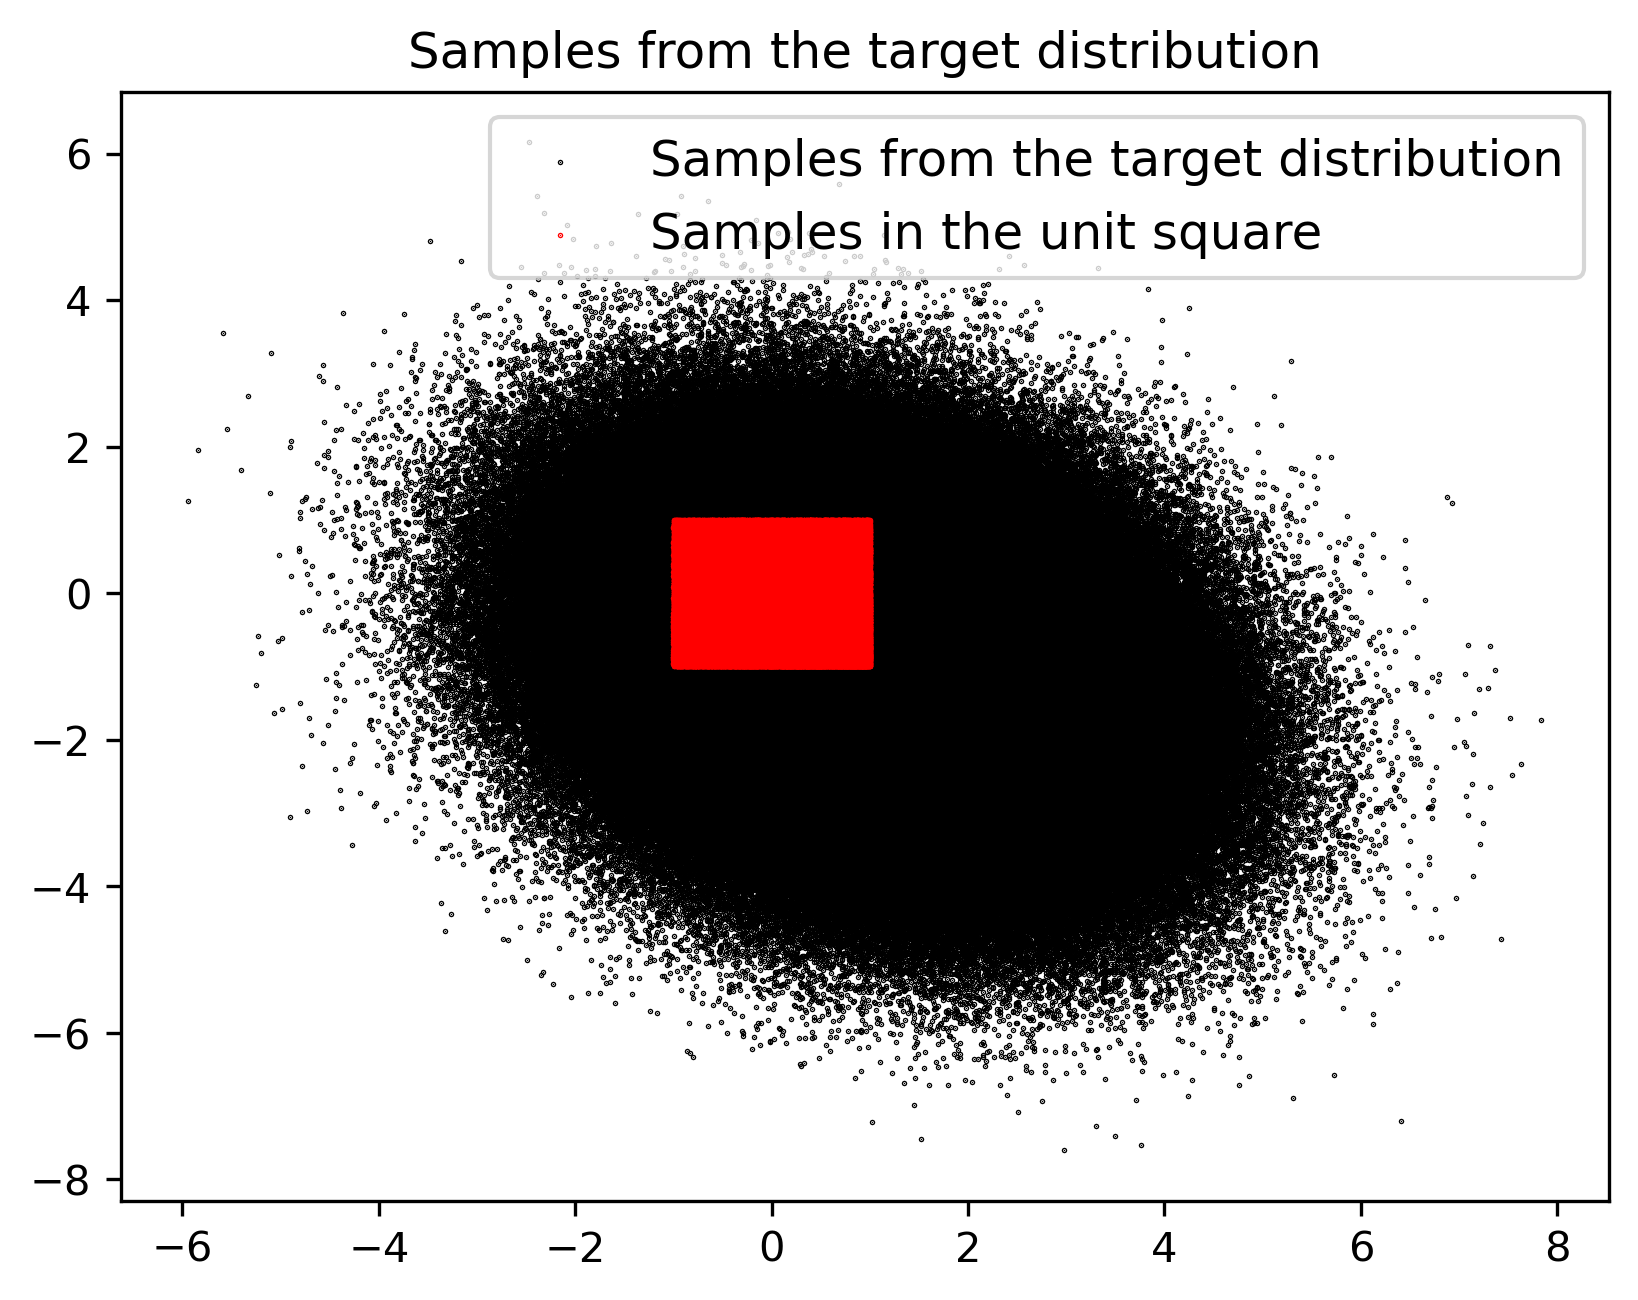

In [179]:
in_sq = x[:,np.where(samples_cmap == 1)]
out_sq = x[:,np.where(samples_cmap == 0)]
plt.scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution")
plt.scatter(in_sq[0,:], in_sq[1,:], s=0.1, c='red', label="Samples in the unit square")
plt.legend(loc="upper right", fontsize=12)
plt.title("Samples from the target distribution")
plt.show()

We now compute the OAIS estimate of $\mathbb{P}(\pi\in Sq)$ using $N=100$ samples at each iteration. We will run the algorithm for $10^5$ iterations, and the learning rate at iteration $k$ will be set to $\alpha_k = \frac{10^{-4}}{k}$.

In [198]:
N = 1000
Niter = int(1e5)
alpha = 1e-4

# run OAIS using while loop to re run if any error occurs
results, distributions = OAIS(phi, pi, q, alpha, N, Niter)


  0%|          | 494/100000 [00:19<1:06:52, 24.80it/s]


KeyboardInterrupt: 

In [188]:
X = np.linspace(-20, 20, 100)
Y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(X, Y)
def fill_z(p):
    Z = np.zeros((100, 100))
    for i in range(100):
        for j in range(100):
            Z[i,j] = p.pdf(np.array([X[i,j], Y[i,j]]))
    return Z

#plt.contourf(X, Y, fill_z(q), cmap='Blues')

In [189]:
dist_to_get = [0, Niter//4, 2*Niter//4, 3*Niter//4, Niter]
in_out_dict = {}
for i in dist_to_get:
    d = distributions[i]
    samples = d.sample(int(1e6))
    samples_cmap = np.apply_along_axis(phi, 0, samples)
    in_sq = samples[:,np.where(samples_cmap == 1)]
    out_sq = samples[:,np.where(samples_cmap == 0)]
    in_out_dict[i] = (in_sq, out_sq)

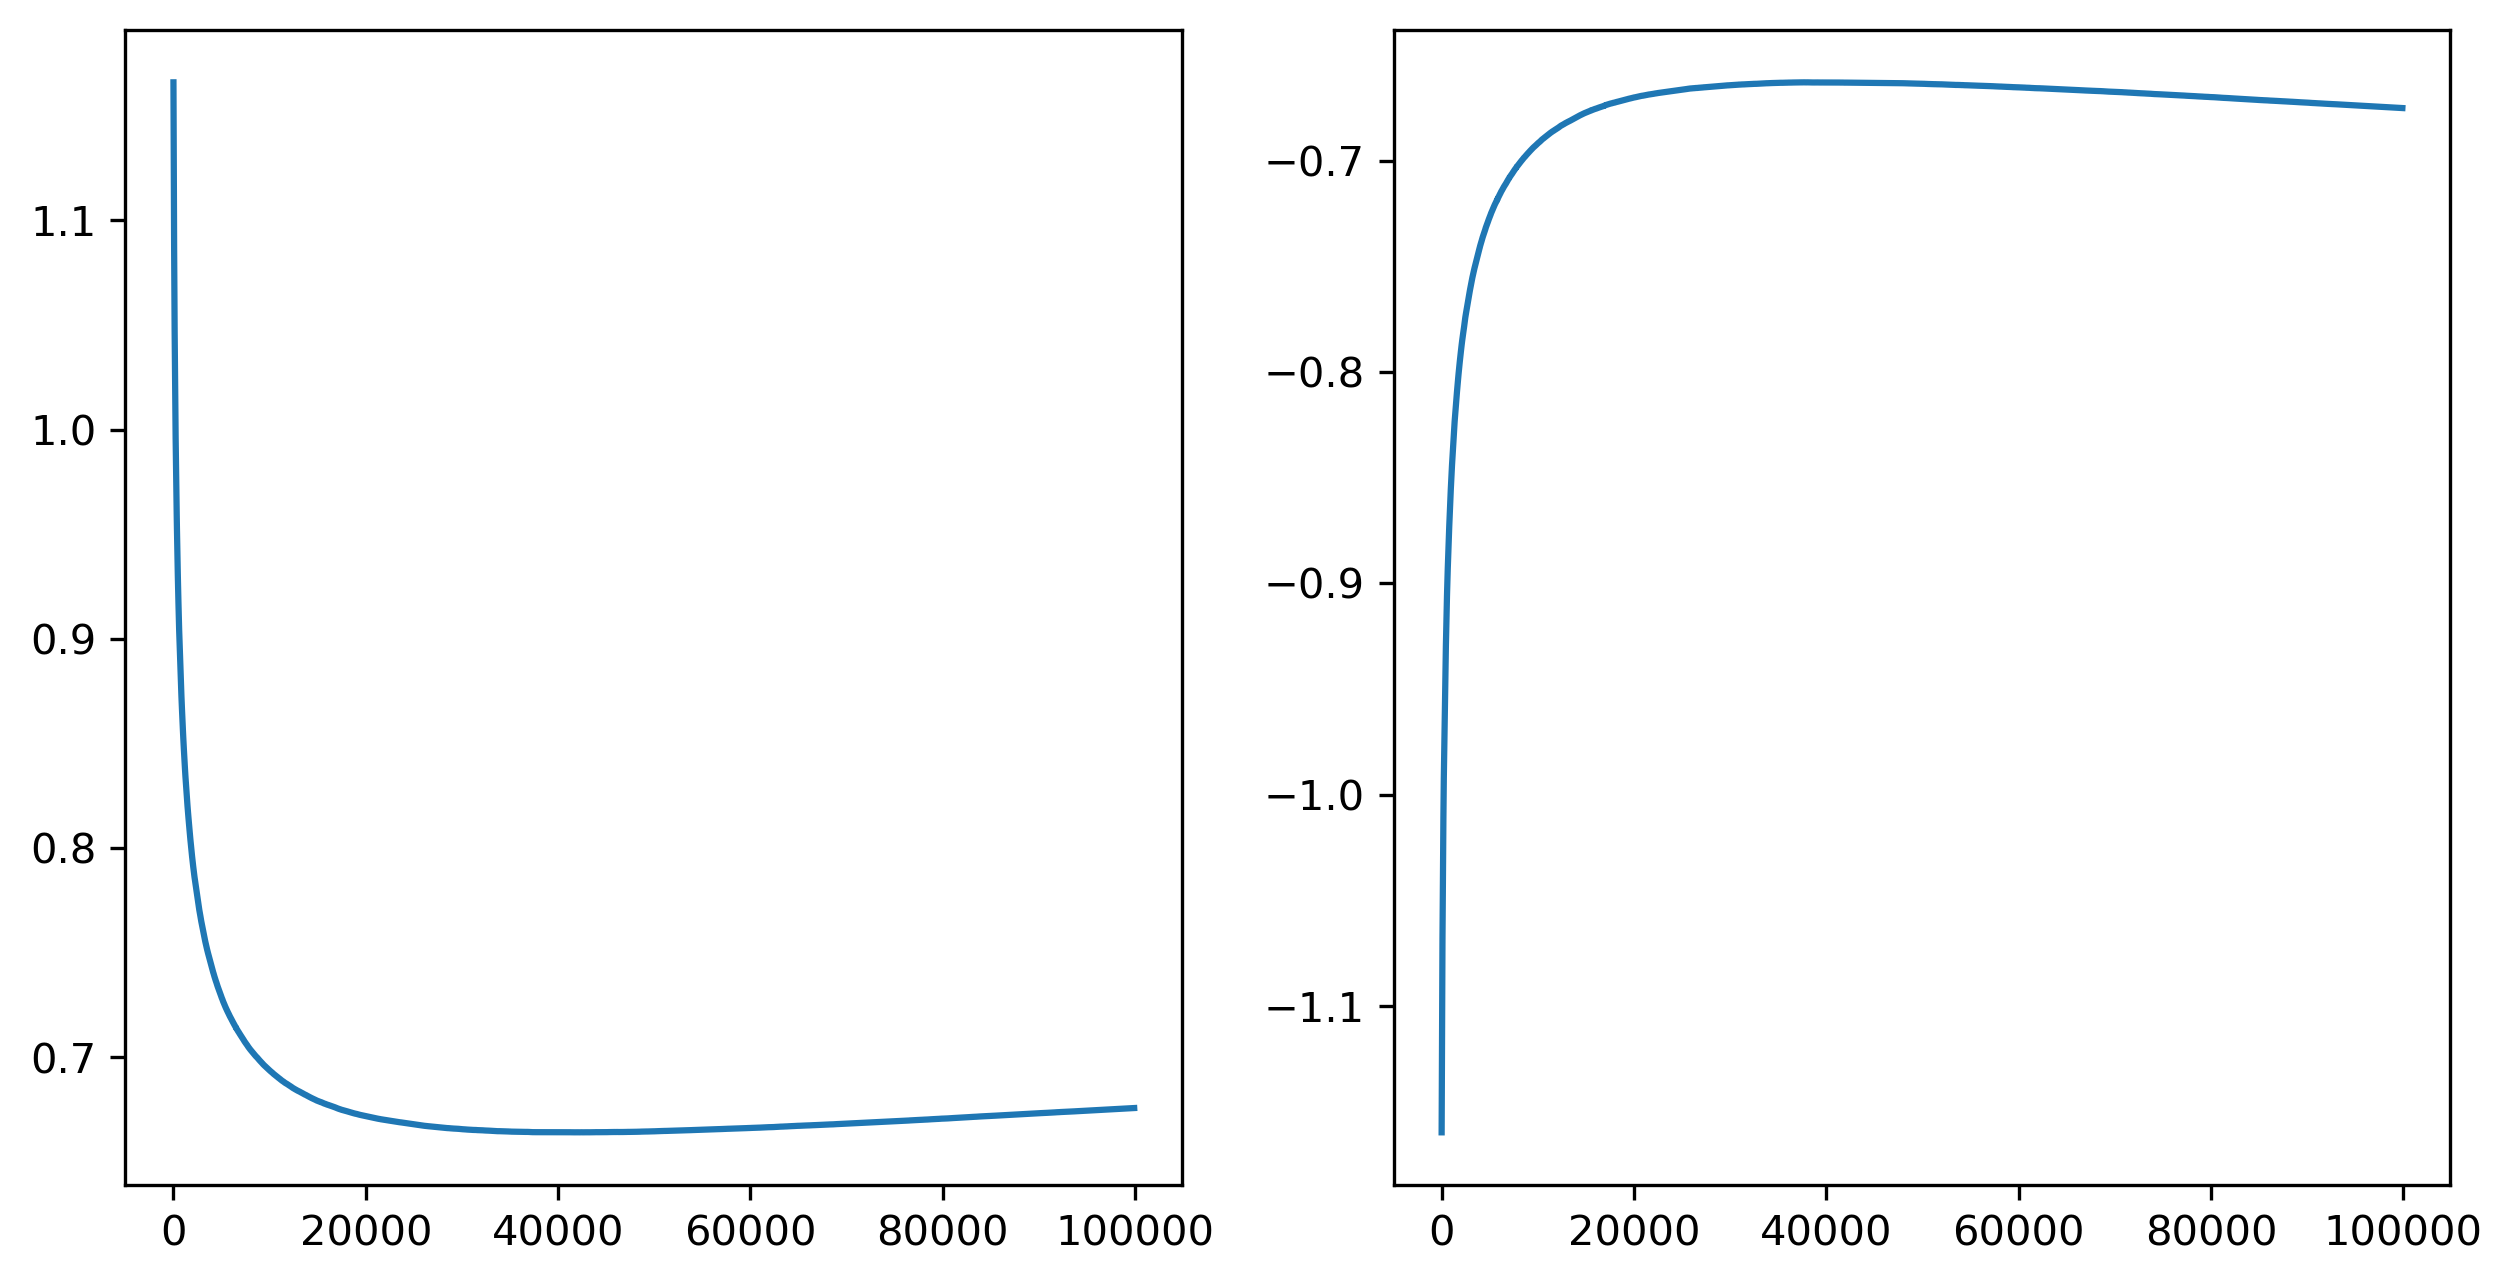

In [195]:
m1 = [distributions[i].mu[0] for i in range(100, Niter)]
m2 = [distributions[i].mu[1] for i in range(100, Niter)]

# make 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(m1, label="m1")
ax2.plot(m2, label="m2")

# TODO change stepsize smaller
# 

Text(0.5, 0.98, 'Covariance matrix entries over time')

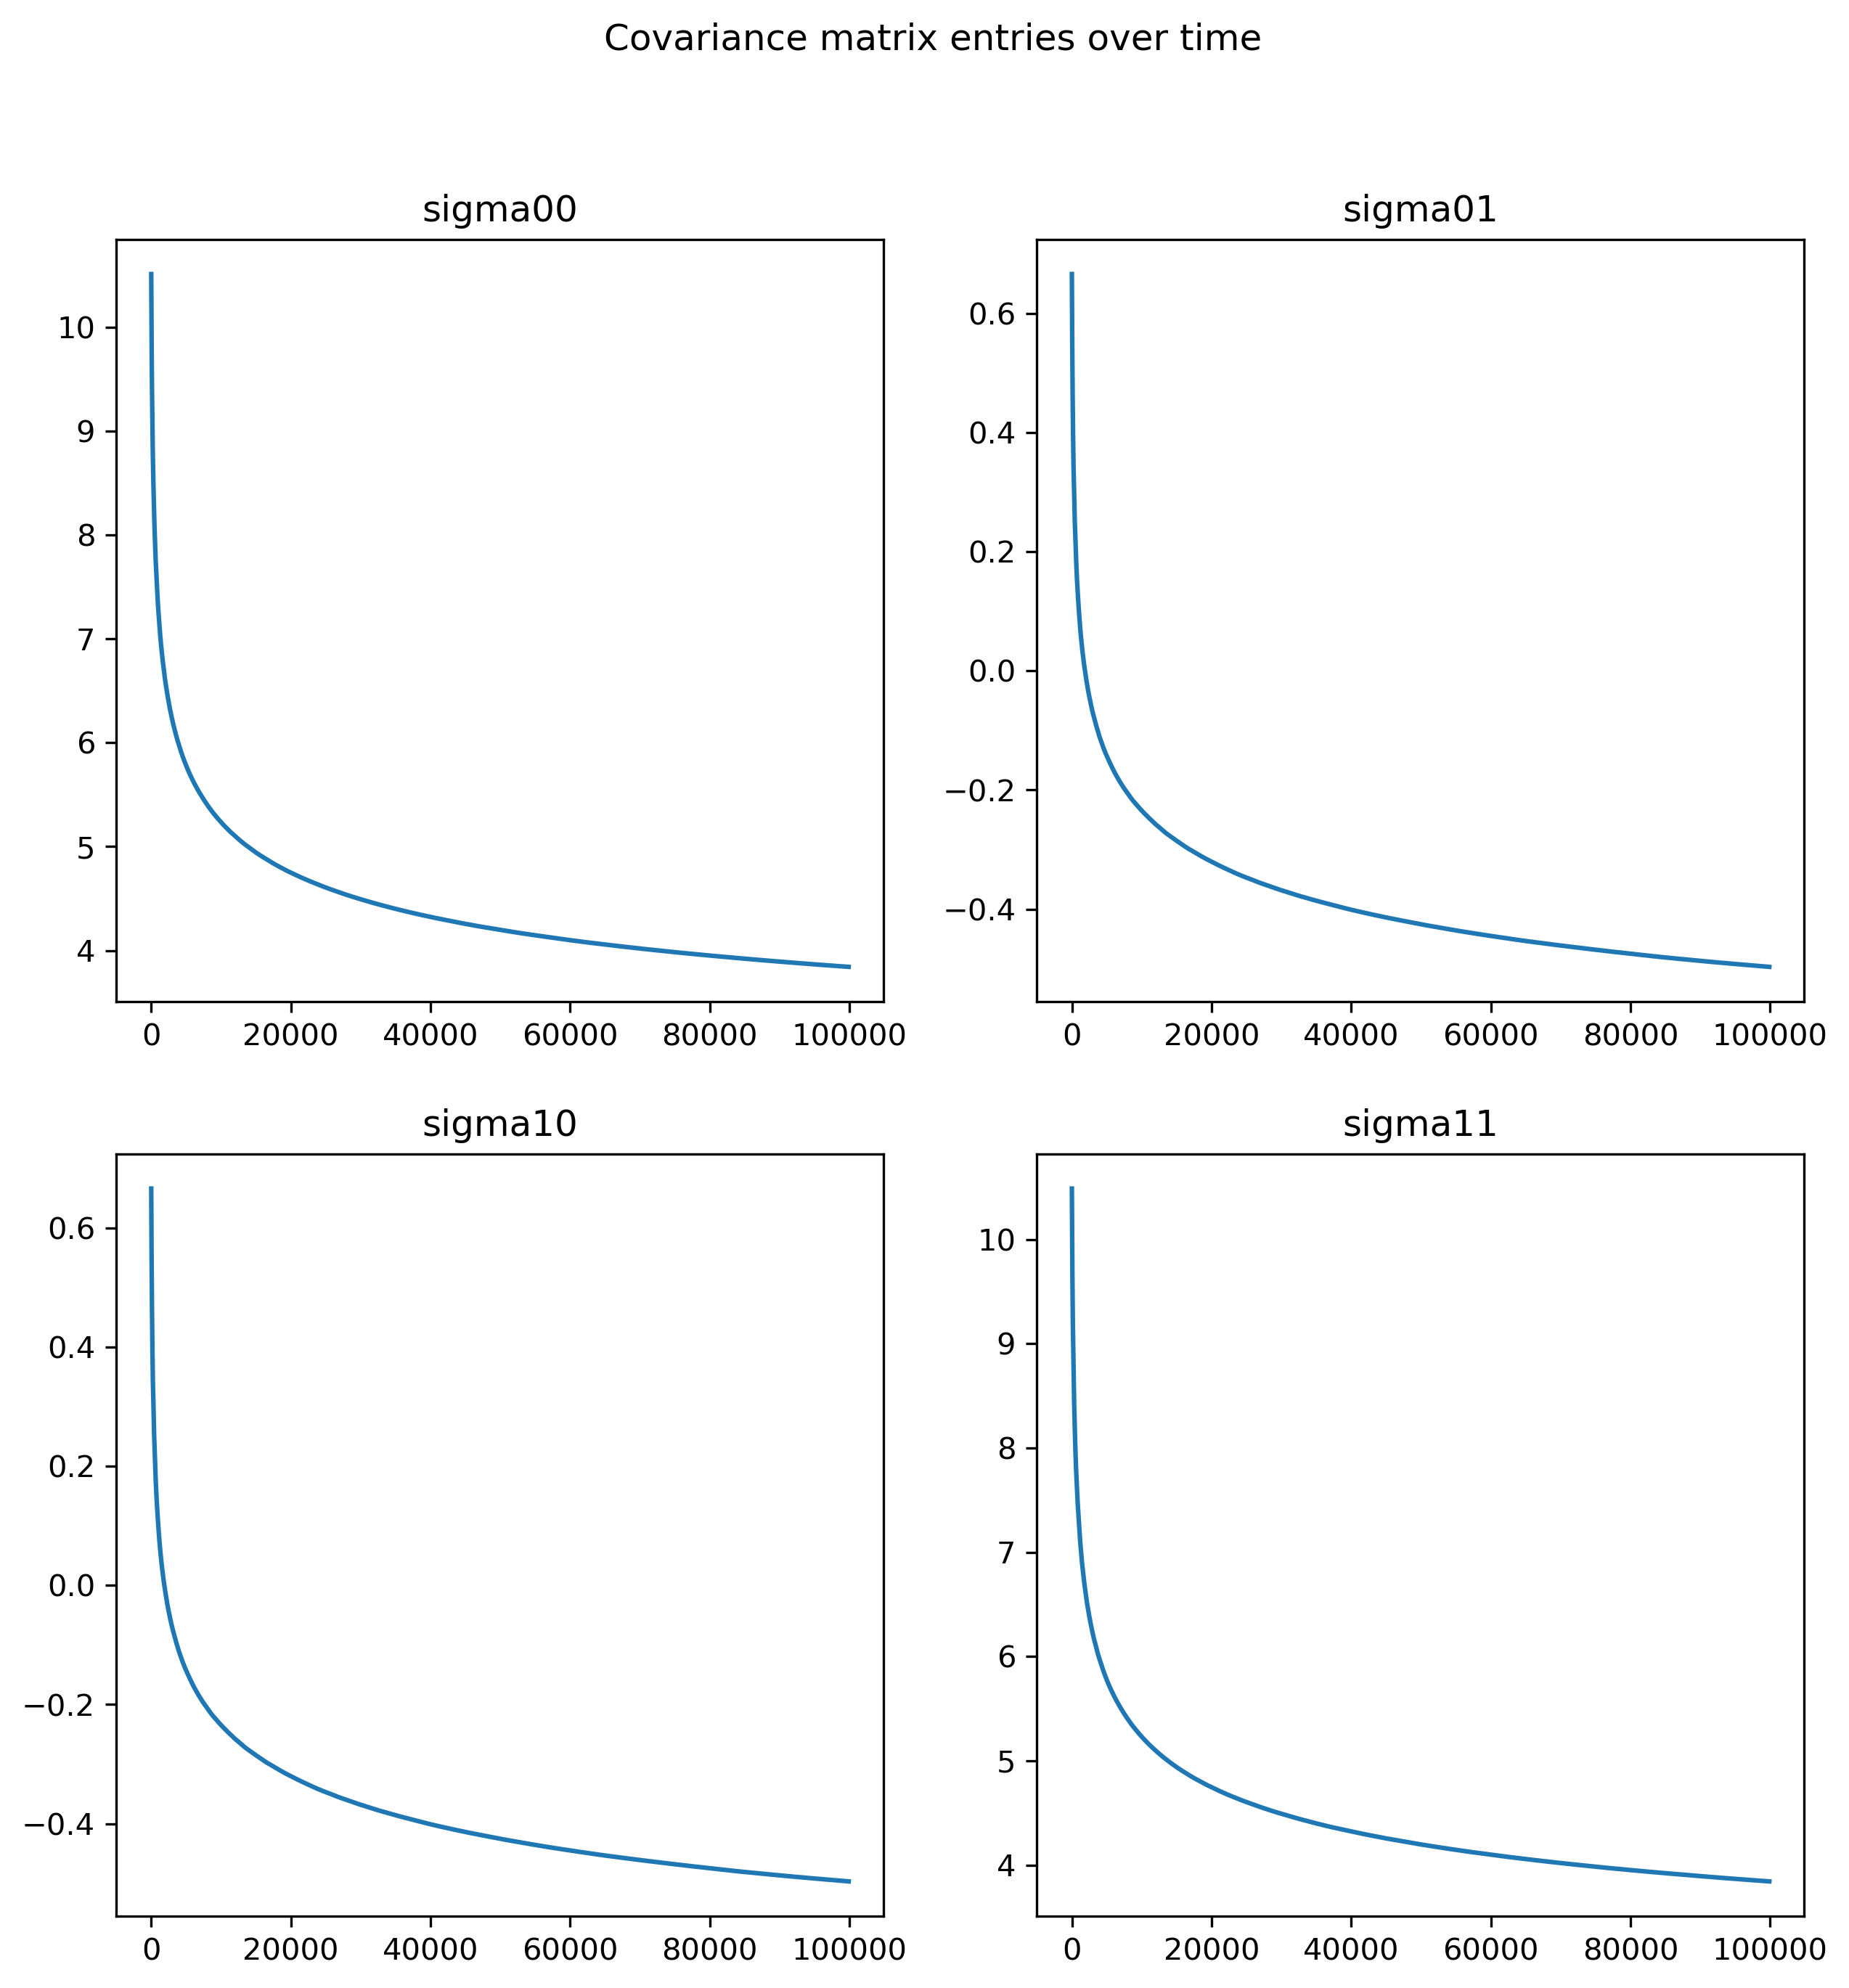

In [196]:
sigma00 = [distributions[i].Sigma[0][0] for i in range(100, Niter)]
sigma11 = [distributions[i].Sigma[1][1] for i in range(100, Niter)]
sigma01 = [distributions[i].Sigma[0][1] for i in range(100, Niter)]
sigma10 = [distributions[i].Sigma[1][0] for i in range(100, Niter)]
true = np.array([[2, -0.5], [-0.5, 2]])
true00 = true[0][0]
true11 = true[1][1]
true01 = true[0][1]
true10 = true[1][0]
# make 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].plot(sigma00)
axs[0, 0].set_title('sigma00')
axs[0, 1].plot(sigma01)
axs[0, 1].set_title('sigma01')
axs[1, 0].plot(sigma10)
axs[1, 0].set_title('sigma10')
axs[1, 1].plot(sigma11)
axs[1, 1].set_title('sigma11')
fig.suptitle('Covariance matrix entries over time')

# plot entries of the covariance matrix

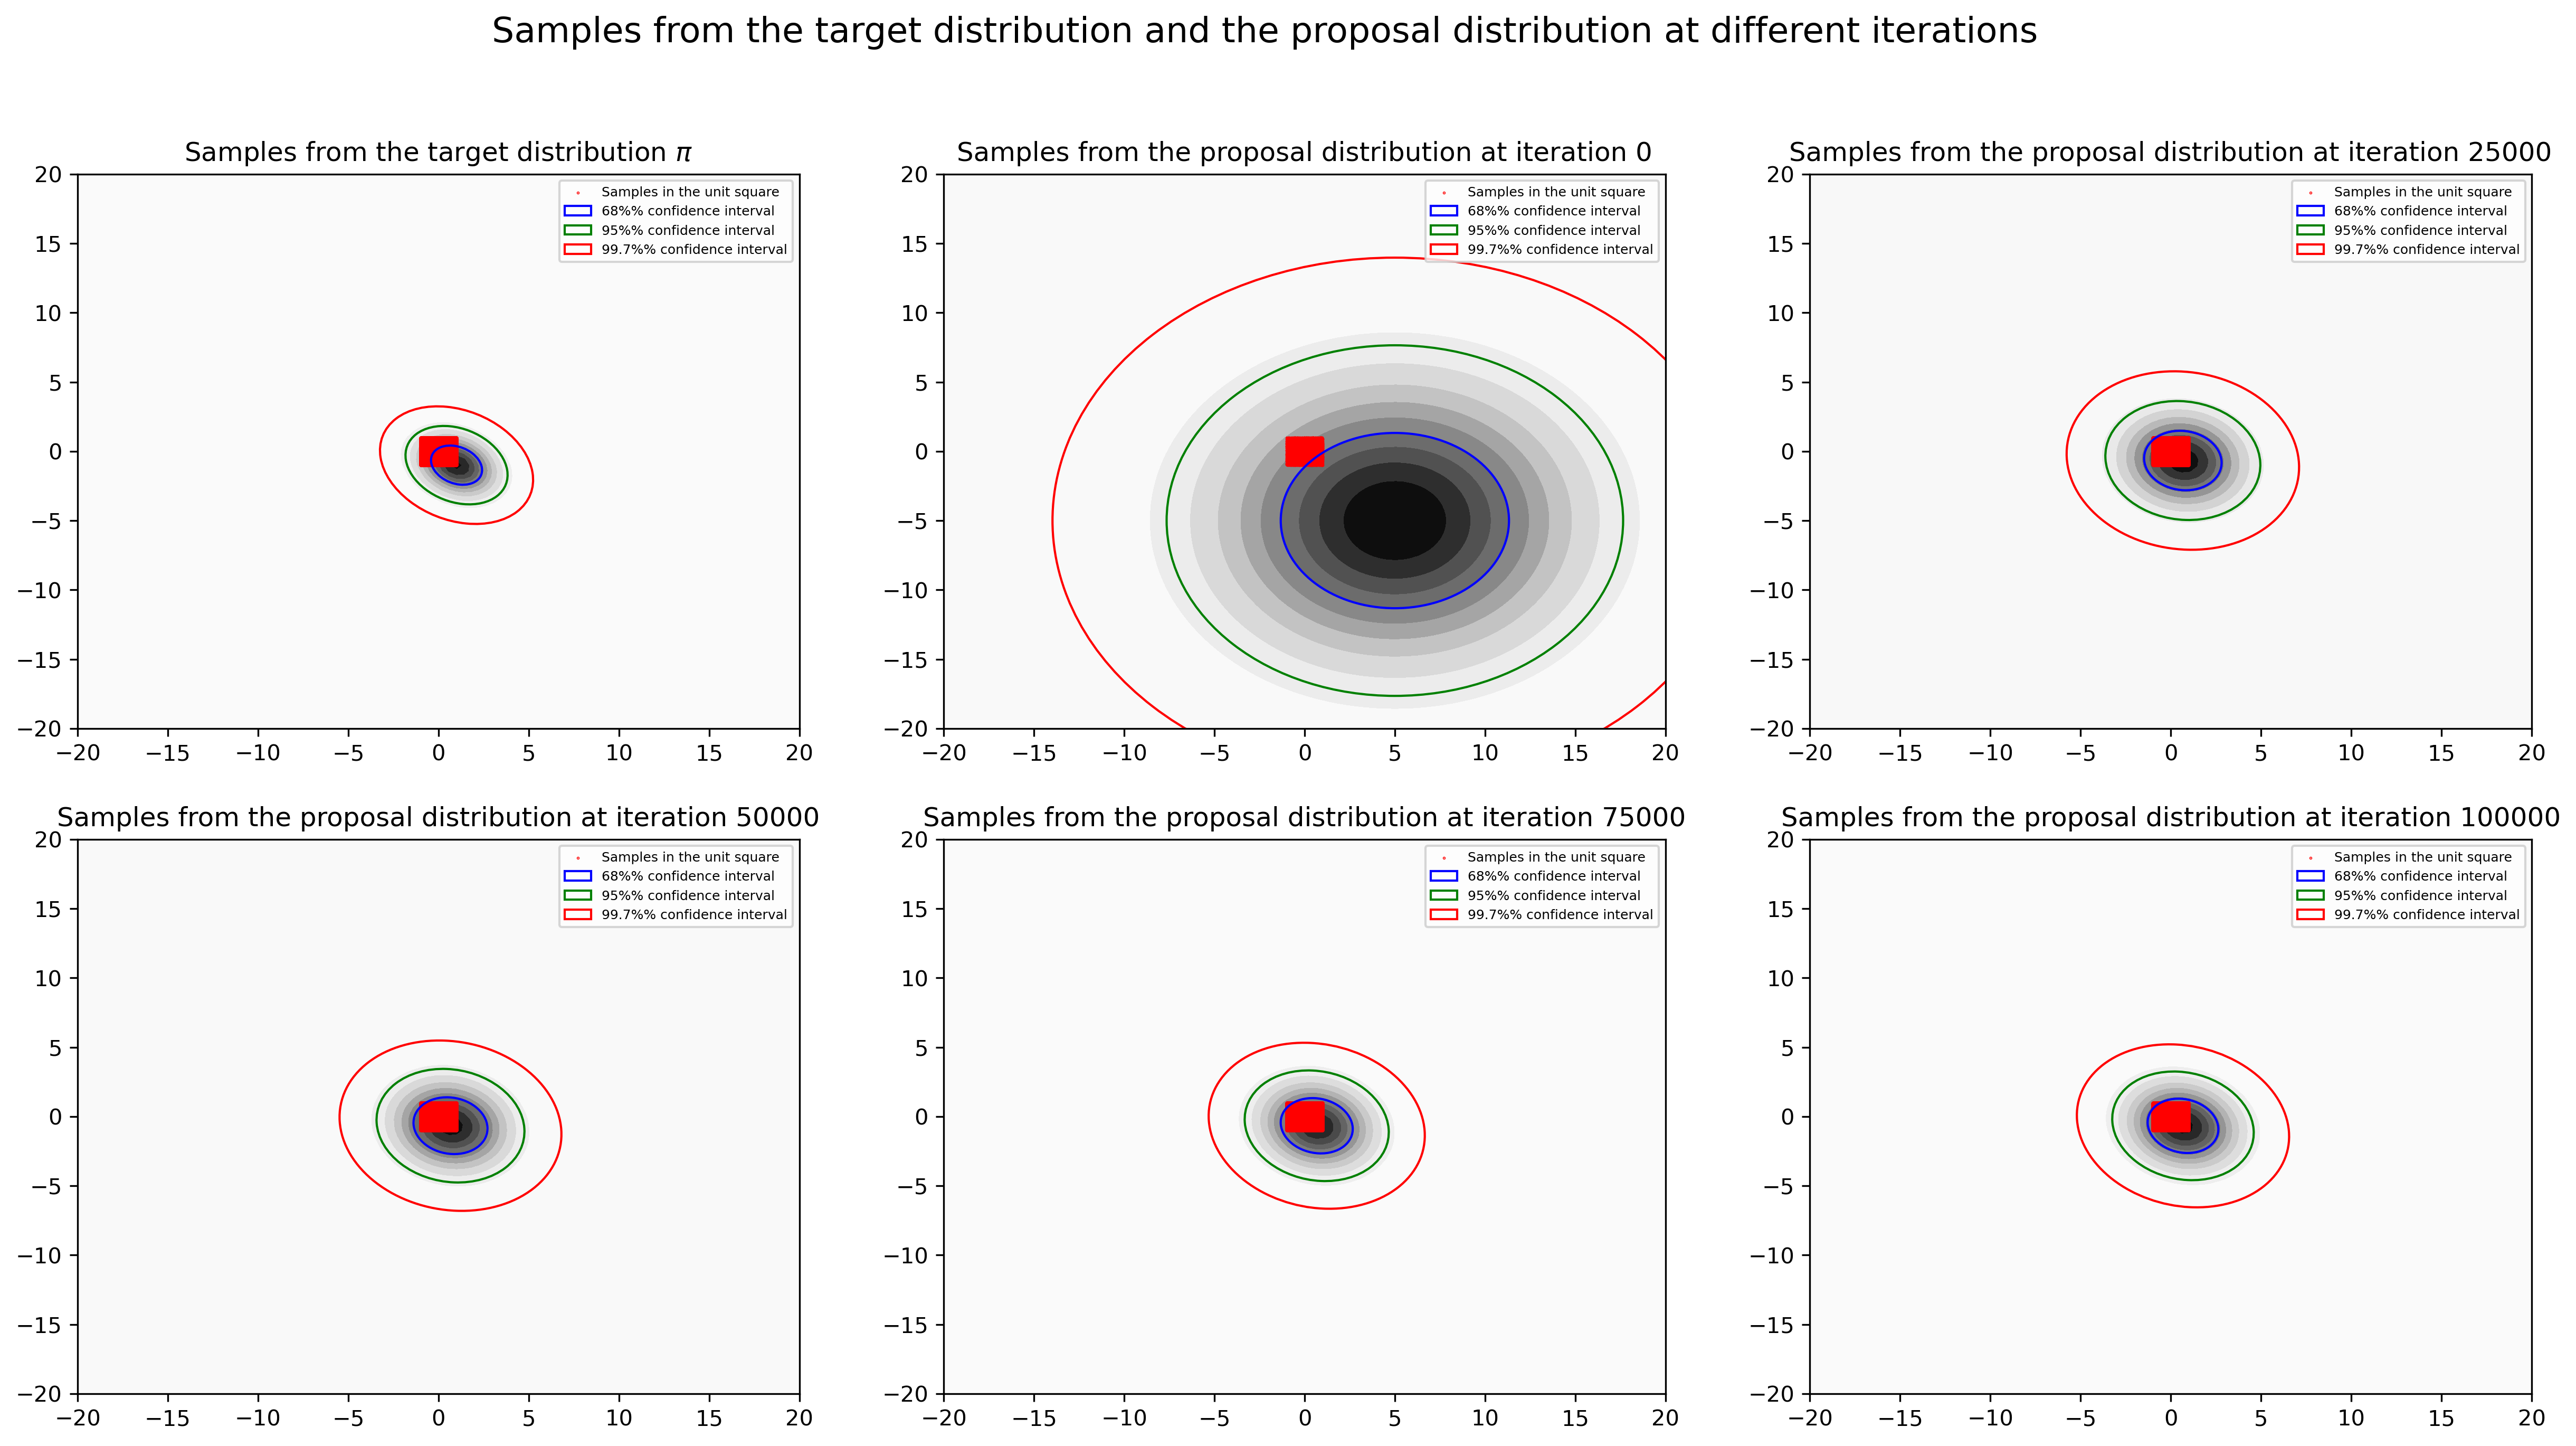

In [197]:
# create 2 by 2 subplots
fig, axs = plt.subplots(2, 3, figsize=(20,10))
#axs[0,0].scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution", zorder=-5)
axs[0,0].scatter(in_sq[0,:], in_sq[1,:], s=0.1, c='red', label="Samples in the unit square", zorder=-5)
Z_pi = fill_z(pi)
axs[0,0].contourf(X, Y, Z_pi, levels=10, cmap="Greys", zorder=-10)
pi.construct_ellipse(1, axs[0,0], "blue", label="68%% confidence interval")
pi.construct_ellipse(2, axs[0,0], "green", label="95%% confidence interval")
pi.construct_ellipse(3, axs[0,0], "red", label="99.7%% confidence interval")
axs[0,0].legend(loc="upper right", fontsize=6)
axs[0,0].set_xlim(-20, 20)
axs[0,0].set_ylim(-20, 20)
axs[0,0].set_title("Samples from the target distribution $\pi$")

remaining_axs = [axs[0,1],axs[0,2],axs[1,0],axs[1,1], axs[1,2]]

for i, ax in zip(dist_to_get, remaining_axs):
    in_sq, out_sq = in_out_dict[i]
    #ax.scatter(out_sq[0,:], out_sq[1,:], s=0.1, c='black', label="Samples from the target distribution", zorder=-5)
    ax.scatter(in_sq[0,:], in_sq[1,:], s=0.1, c='red', label="Samples in the unit square", zorder=-5)
    Z_d = fill_z(distributions[i])
    ax.contourf(X, Y, Z_d, levels=10, cmap="Greys", zorder=-10)

    distributions[i].construct_ellipse(1, ax, "blue", label="68%% confidence interval")
    distributions[i].construct_ellipse(2, ax, "green" , label="95%% confidence interval")
    distributions[i].construct_ellipse(3, ax, "red", label="99.7%% confidence interval")
    ax.set_ylim(-20, 20)
    ax.set_xlim(-20, 20)
    ax.legend(loc="upper right", fontsize=6)
    ax.set_title("Samples from the proposal distribution at iteration {}".format(i))

fig.suptitle("Samples from the target distribution and the proposal distribution at different iterations", fontsize=16)
fig.tight_layout
plt.show()

In [193]:
distributions[-1]

N([ 0.67578644 -0.67509862], [[ 3.84323204 -0.49681967]
 [-0.49681967  3.84278024]])

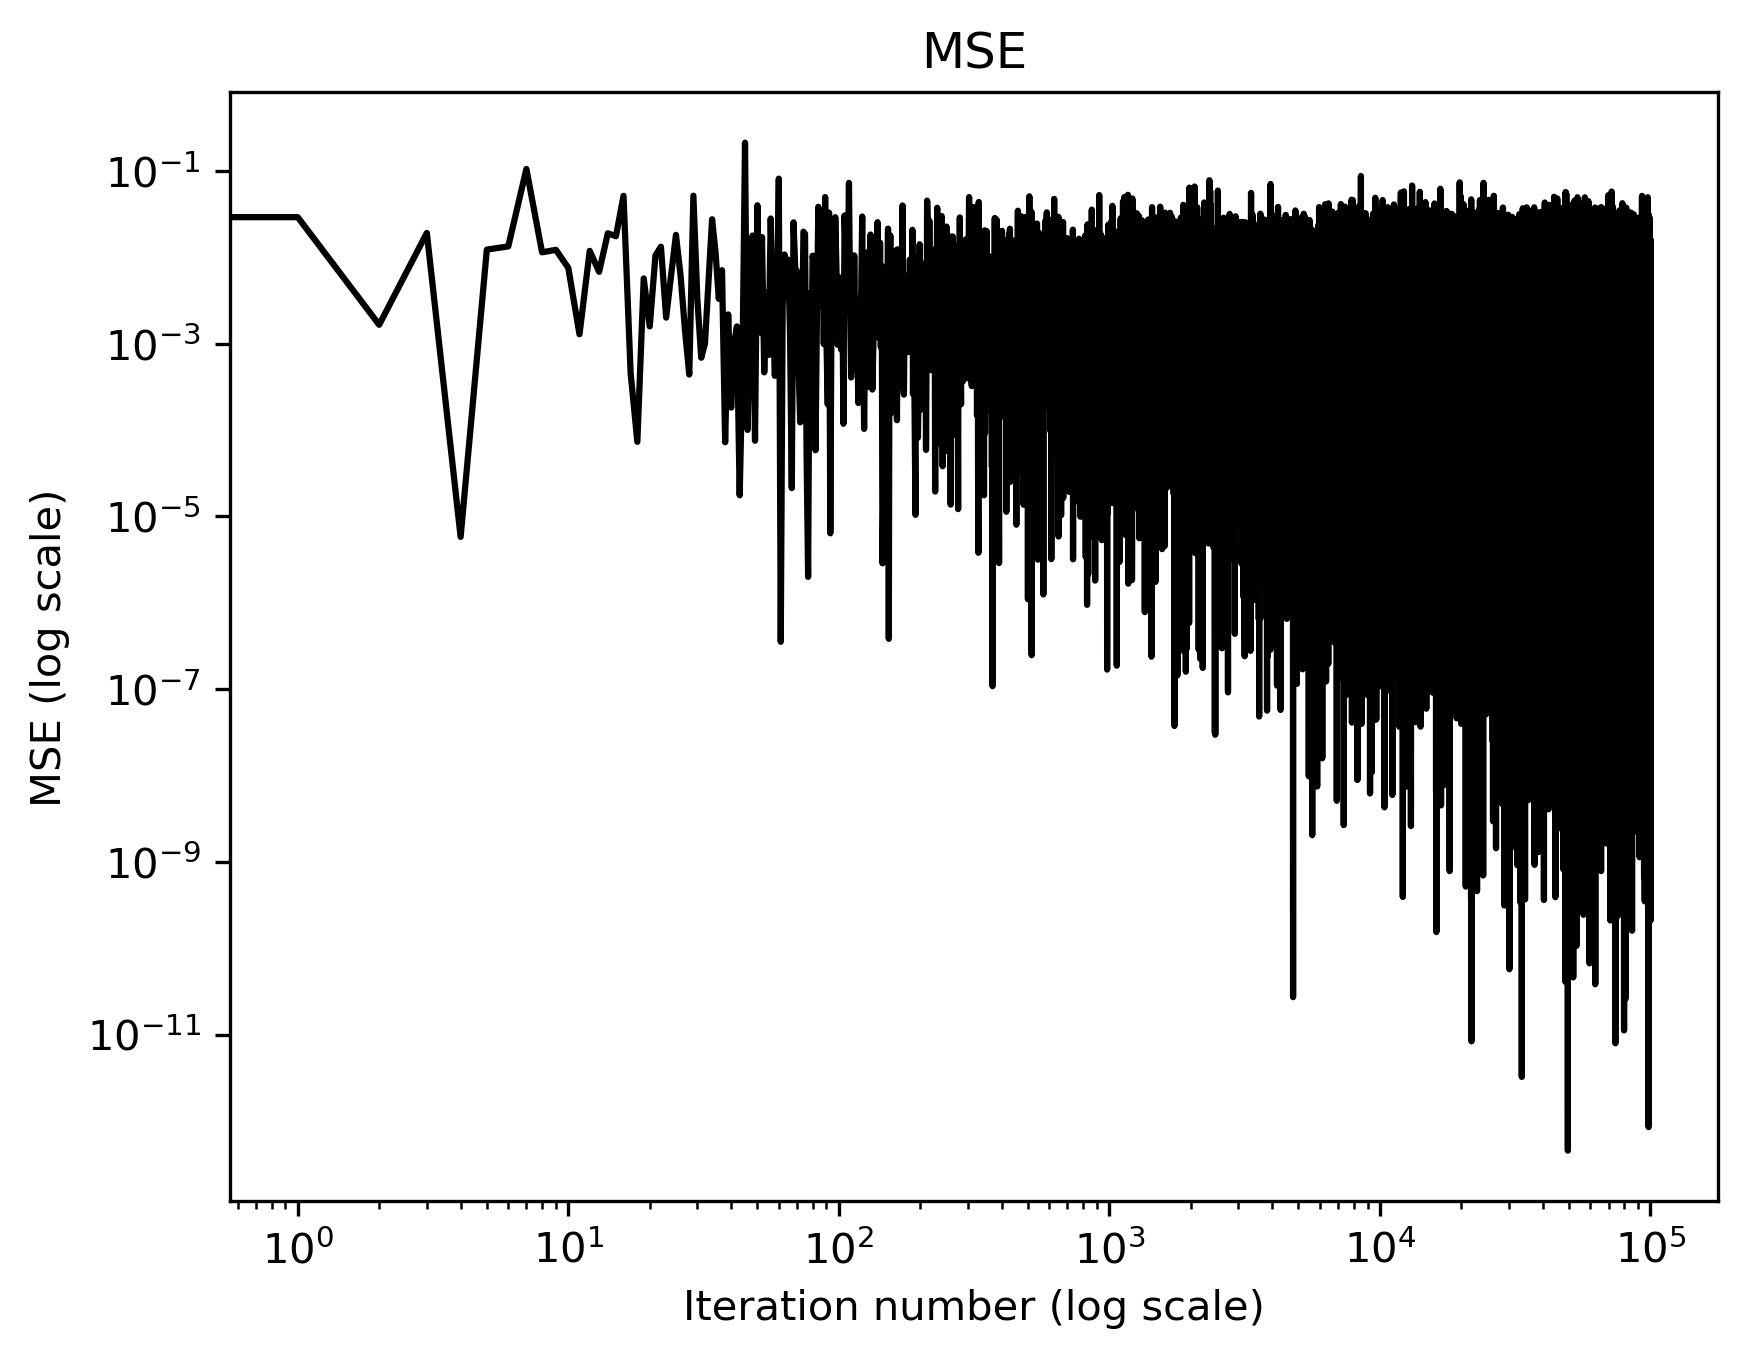

In [201]:
abs_err = np.abs(results-GT)**2
plt.plot(abs_err, color="black")
plt.title("MSE")
plt.xlabel("Iteration number (log scale)")
plt.xscale("log")

plt.ylabel("MSE (log scale)")
plt.yscale("log")
plt.show()



Another measure of computing how close two probability distributions are is through the Kullbacl-Liebler (KL) divergence. Given two probability distributions $P$ and $Q$, the formula for KL divergence is:

$$
KL(P||Q) = \int_{\mathbb{R}^n}p(x)\log\frac{p(x)}{q(x)}dx
$$

For $P,\, Q$ normally distributed it is known that the formula above can be simplified to:

$$
KL(P||Q) = \frac{1}{2}\left(\log\frac{|\Sigma_q|}{|\Sigma_p|} - n + tr(\Sigma_q^{-1}\Sigma_p) + (\mu_q-\mu_p)^\top\Sigma_q^{-1}(\mu_q-\mu_p)\right)
$$

We implement this below and compute $KL(\pi||q_{\theta_k})$ as $k$ increases.

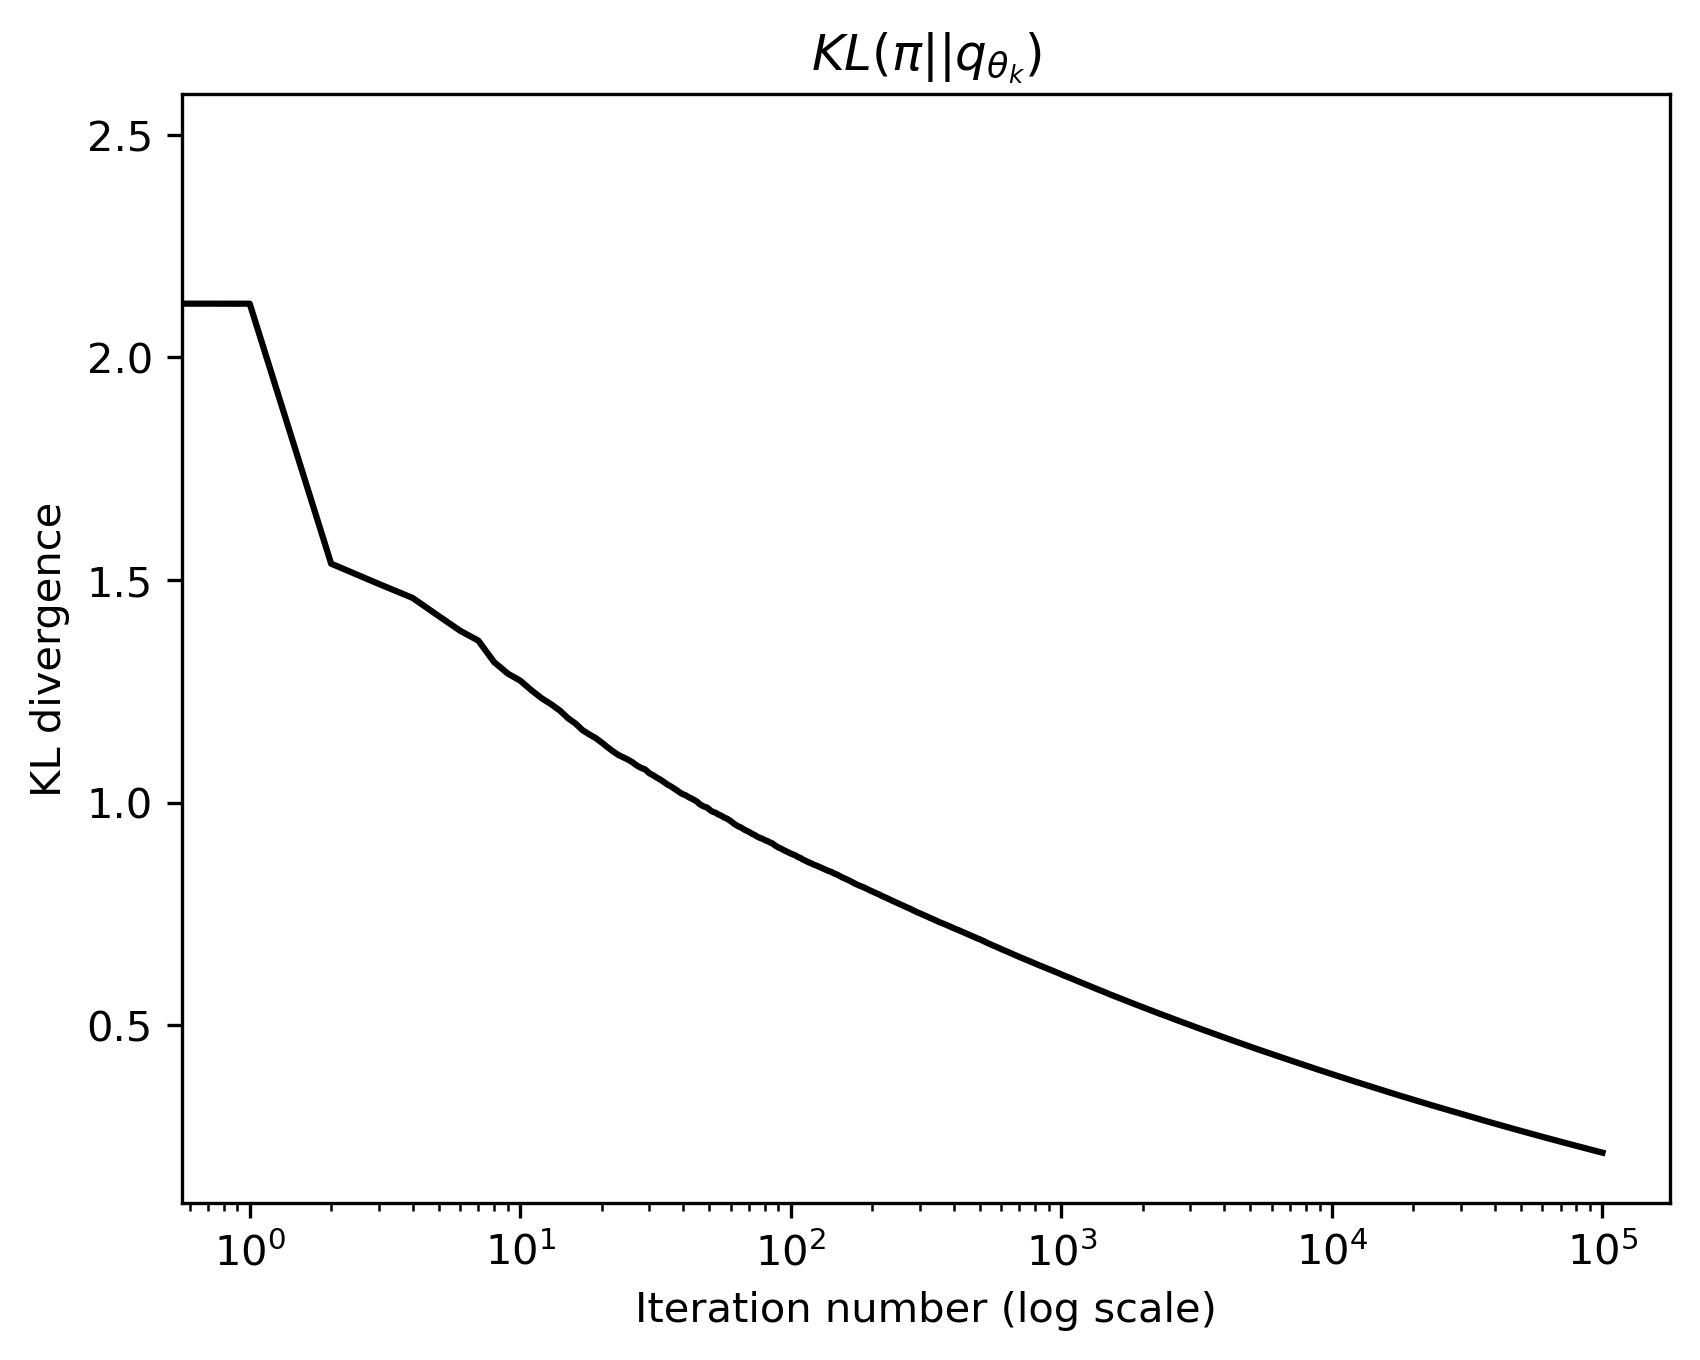

In [199]:
def KL(p, q):
    # from https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians

    sigma_p = p.Sigma
    sigma_q = q.Sigma
    mu_p = p.mu
    mu_q = q.mu

    return 0.5*(np.log(np.linalg.det(sigma_q)/np.linalg.det(sigma_p)) - len(mu_p) + np.trace(np.linalg.inv(sigma_q)@sigma_p) + (mu_q-mu_p).T@np.linalg.inv(sigma_q)@(mu_q-mu_p))

KL_divs = [KL(pi, d) for d in distributions]
plt.plot(KL_divs, color="black")
plt.title("$KL(\pi||q_{\\theta_k})$")
plt.xlabel("Iteration number (log scale)")
plt.xscale("log")
plt.ylabel("KL divergence")
plt.show()
